In [1]:
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline

Let's pull in our current MLP code:

In [2]:
words = open('../l2_makemore/names.txt').read().splitlines()
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

In [3]:
def forward(x, parameters):
    C, W1, b1, W2, b2 = parameters
    emb = C[x]
    h = (emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1) + b1
    h = h.tanh()
    h = (h @ W2) + b2
    return h # returns logits

def optimize_step(x, y, parameters, lr=0.1):
    logits = forward(x, parameters)
    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    return loss.item()

def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size):
    C = torch.randn((num_chars, embedding_size), requires_grad=True)
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size), requires_grad=True)
    b1 = torch.randn(hidden_layer_size, requires_grad=True)
    W2 = torch.randn((hidden_layer_size, num_chars), requires_grad=True)
    b2 = torch.randn(num_chars, requires_grad=True)

    return [C, W1, b1, W2, b2]

def build_inputs_and_labels(words, block_size):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

def train_dev_test_split(words, train_size=0.8, dev_size=0.1):
    random.shuffle(words)
    assert train_size + dev_size < 1
    num_words = len(words)
    train_split = int(num_words * train_size)
    dev_split = int(num_words * (train_size + dev_size))
    train_words = words[:train_split]
    dev_words = words[train_split:dev_split]
    test_words = words[dev_split:]
    return train_words, dev_words, test_words

def gradient_descent(x, y, parameters, iterations=100, minibatch_size=100, lr=0.1, lr_decay=0.01, print_every=10):
    losses = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        loss = optimize_step(xi, yi, parameters, lr)
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr *= (1 - lr_decay)
    return losses

@torch.no_grad()
def evaluate(x, y, parameters):
    logits = forward(x, parameters)
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

@torch.no_grad()
def generate(parameters, block_size, min_chars=3, max_chars=20):
    C, W1, b1, W2, b2 = parameters
    context = [0] * block_size
    out = []
    for i in range(max_chars):
        logits = forward(torch.tensor([context]), parameters)
        probs = torch.nn.functional.softmax(logits, dim=1)
        if i < min_chars:
            probs[0, 0] = 0
        ix = torch.multinomial(probs, 1).item()
        if ix == 0:
            break
        out.append(itos[ix])
        context = context[1:] + [ix]

    return ''.join(out)


    

The first task we will complete in this lecture is fixing the initial loss. We also looked at this issue in the exercises for the last lecture but we'll solve it slightly differently here. 

We can observe that our initial loss is high when we begin to train the model:


In [4]:
train_words, dev_words, test_words = train_dev_test_split(words)


In [5]:
block_size = 3
embedding_size = 10
hidden_layer_size = 100
num_chars = len(chars)
train_X, train_Y = build_inputs_and_labels(train_words, block_size=3)
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size)
losses = gradient_descent(train_X, train_Y, parameters, iterations=1, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000)

Iteration 0 loss: 18.162782669067383


However, if we were to just guess the next character randomly -- we could expect to guess correctly roughly 1/27 of the time. 
This would translate to a log-likelihood loss of 3.29:

In [6]:
-torch.log(torch.tensor(1/27))

tensor(3.2958)

However, our initial loss was much higher! This is because our logits are taking on more extreme values than what we saw in the uniform probability distribution shown above:

In [7]:
logits = forward(torch.tensor([[0, 0, 0]]), parameters)
logits

tensor([[ -7.8749,  -5.2379,  -7.8370,  -1.3716,  -4.8796,   1.1478,  -3.9465,
          -1.9287,  10.3727,  10.9121,   9.4980,   8.1253,  -2.7629,  -5.2121,
           6.6777,   0.3946, -10.5363,   2.1994,   0.9927,   8.0469,   8.1851,
          -9.8432,  -1.1020,  -3.1270,  -8.6212,  -8.2483,  -7.9609]],
       grad_fn=<AddBackward0>)

-- vs --

In [8]:
torch.full((1, 27), torch.tensor(1/27))

tensor([[0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
         0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370]])

We can fix this by ensuring that our output probability distribution is roughly uniform upon initialization. In the last homework, I initialized every weight in the NN to be 0.5. This accomplishes the same thing, but in a normal neural net we'd expect some weights to take on negative values and some to take on positive values -- so it is likely more prudent to set these initial weights closer to zero. However -- as we show later -- setting weights to exactly zero is ill-advised.

For now we can change our *init_parameters* function to init biases to zero and weights to near-zero: 

In [9]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, weight_multiplier=0.01):
    C = torch.randn((num_chars, embedding_size)) 
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size)) 
    b1 = torch.randn(hidden_layer_size)
    W2 = torch.randn((hidden_layer_size, num_chars)) * weight_multiplier
    b2 = torch.zeros(num_chars)

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return parameters

In [10]:
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, 0.1)
losses = gradient_descent(train_X, train_Y, parameters, iterations=1, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000)

Iteration 0 loss: 3.749765157699585


Now our loss is much closer to what we'd expect!

In [11]:
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, 0.1)
losses = gradient_descent(train_X, train_Y, parameters, iterations=200000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000)

Iteration 0 loss: 3.7897610664367676
Iteration 10000 loss: 2.0145211219787598
Iteration 20000 loss: 2.337879180908203
Iteration 30000 loss: 2.0510077476501465
Iteration 40000 loss: 2.3087539672851562
Iteration 50000 loss: 2.0767362117767334
Iteration 60000 loss: 1.970555305480957
Iteration 70000 loss: 2.0461502075195312
Iteration 80000 loss: 2.1510698795318604
Iteration 90000 loss: 2.0769996643066406
Iteration 100000 loss: 2.238422155380249
Iteration 110000 loss: 2.177921772003174
Iteration 120000 loss: 2.153441905975342
Iteration 130000 loss: 1.9256317615509033
Iteration 140000 loss: 2.144674301147461
Iteration 150000 loss: 2.1046009063720703
Iteration 160000 loss: 2.4300007820129395
Iteration 170000 loss: 2.0579631328582764
Iteration 180000 loss: 2.058760404586792
Iteration 190000 loss: 2.033414602279663


In [12]:
dev_X, dev_Y = build_inputs_and_labels(dev_words, block_size=3)
print(f'Dev Loss = {evaluate(dev_X, dev_Y, parameters)}')

Dev Loss = 2.1655166149139404


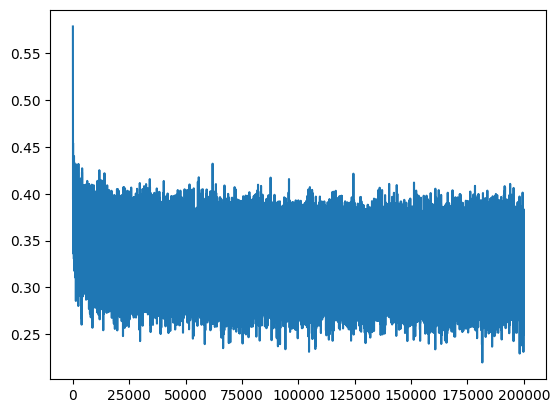

In [13]:
plt.plot(torch.tensor(losses).log10())
plt.show()

In [14]:
print(f'Train Loss = {evaluate(train_X, train_Y, parameters)}')
print(f'Dev Loss = {evaluate(dev_X, dev_Y, parameters)}')

Train Loss = 2.122659683227539
Dev Loss = 2.1655166149139404


We can see that our loss still decreases like we expect, but much more gradually!

Our next order of business is fixing our saturated tanh-activated layers. The tanh activation squashes values into the range (-1, 1), but if we are not careful many values can end up in the extremeties -1 or 1 -- resulting in a less rich representation of our data. Furthermore, when tanh activations are close to -1 or 1, their gradients are near-zero, meaning it becomes incredibly difficult/impossible to learn good values for those weights, which can make it harder for the network to learn overall.

In [15]:
def forward_and_get_hidden_activations(x, parameters):
    C, W1, b1, W2, b2 = parameters
    emb = C[x]
    pre_h = (emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1) + b1
    h = pre_h.tanh()
    logits = (h @ W2) + b2
    return logits, h, pre_h # returns logits and hidden activations

In [16]:
logits, h, pre_h = forward_and_get_hidden_activations(train_X[:100], parameters)

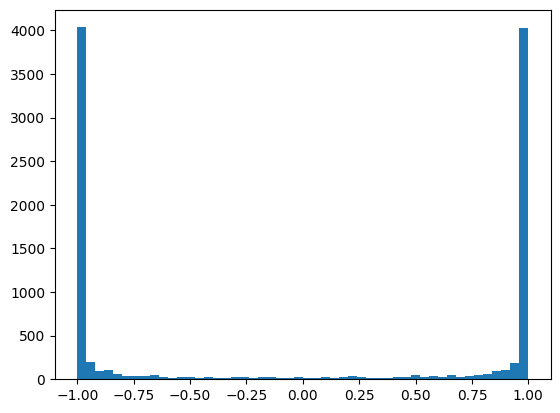

In [17]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

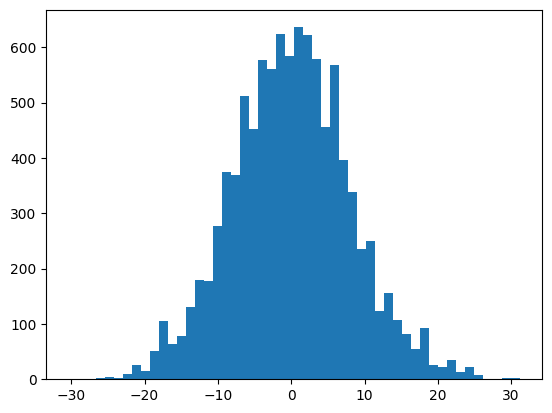

In [18]:
plt.hist(pre_h.view(-1).tolist(), 50)
plt.show()

We can see that this phenomenon is definitely occuring in our trained model -- the tanh activations are mostly either 1 or -1, due to the pre-activations taking on a large range of values. 

We can further analyze the issue by plotting the 'dead' activations:

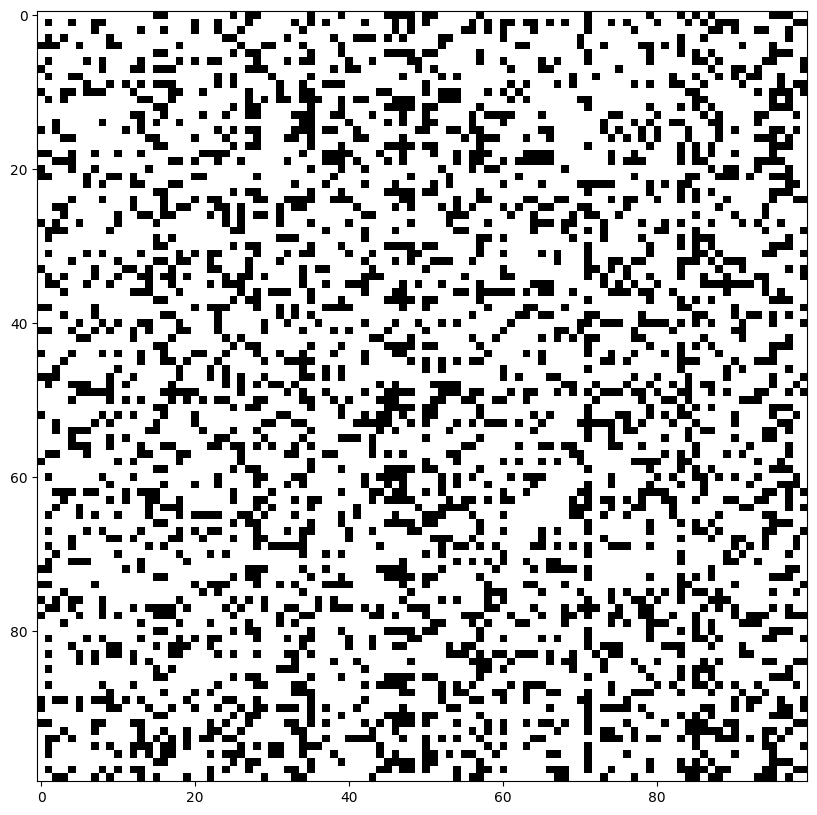

In [19]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Here, white cells indicate a neuron activation in a 'dead' region, i.e. close to -1 or 1. As more activations become dead, the network is in danger of being capable of learning absolutely nothing -- as there are no meaningful gradients to learn from. We can see that all neurons have some live activations, but we could expect to have better results if we had fewer dead neurons.

We can update our *init_parameters* function to shrink parameters such that they take on a nicer distribution and thus produce fewer dead neurons:

In [20]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, weight_multiplier=0.01):
    C = torch.randn((num_chars, embedding_size))
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size)) * weight_multiplier 
    b1 = torch.randn(hidden_layer_size) * weight_multiplier
    W2 = torch.randn((hidden_layer_size, num_chars)) * weight_multiplier
    b2 = torch.zeros(num_chars)

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return parameters

In [21]:
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, 0.1)
logits, h, pre_h = forward_and_get_hidden_activations(train_X[:100], parameters)

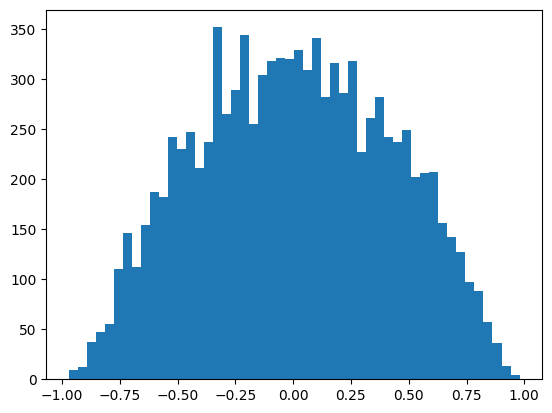

In [22]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

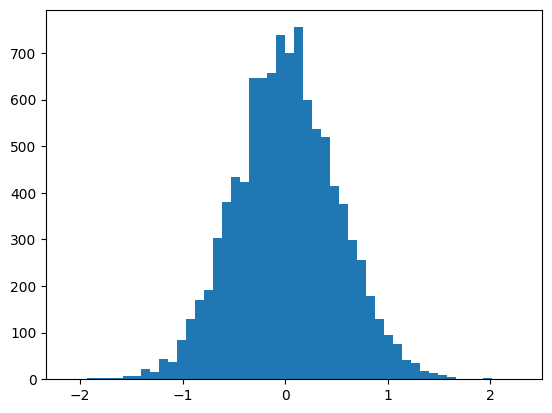

In [23]:
plt.hist(pre_h.view(-1).tolist(), 50)
plt.show()

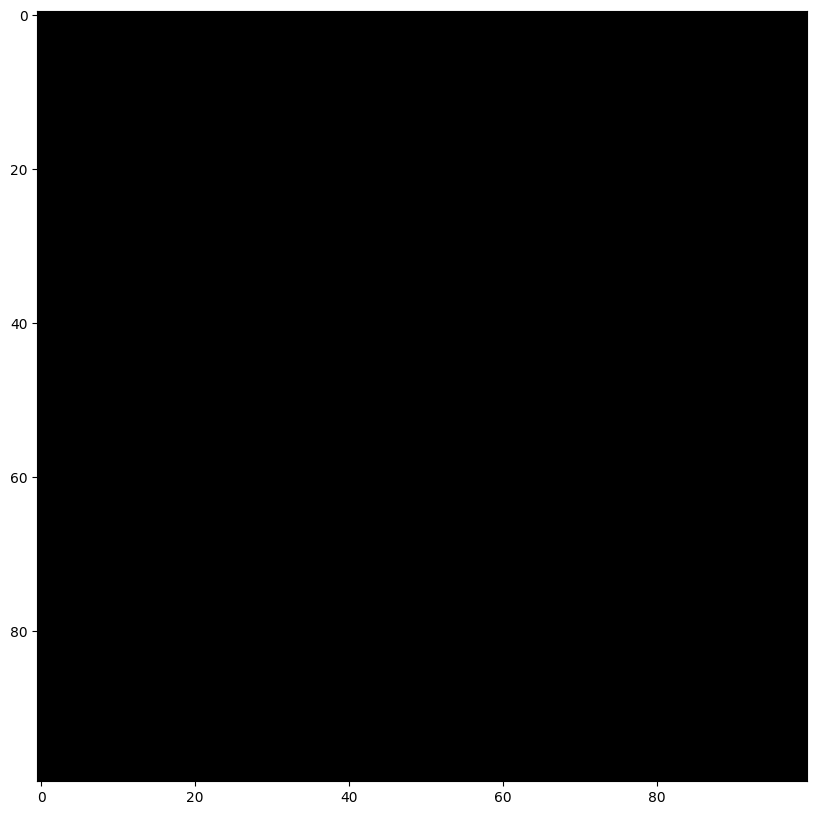

In [24]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Now that we've constrained the pre-activations to take on a smaller range of values, we see that every activation takes on a meaningful gradient!

In [25]:
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, 0.1)
losses = gradient_descent(train_X, train_Y, parameters, iterations=200000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000)

Iteration 0 loss: 3.3763792514801025
Iteration 10000 loss: 2.1484029293060303
Iteration 20000 loss: 2.141895294189453
Iteration 30000 loss: 2.196840524673462
Iteration 40000 loss: 1.9774006605148315
Iteration 50000 loss: 1.9343327283859253
Iteration 60000 loss: 1.9625872373580933
Iteration 70000 loss: 2.0719316005706787
Iteration 80000 loss: 2.044301986694336
Iteration 90000 loss: 2.1988048553466797
Iteration 100000 loss: 2.278012275695801
Iteration 110000 loss: 2.2047359943389893
Iteration 120000 loss: 1.8524245023727417
Iteration 130000 loss: 2.077874183654785
Iteration 140000 loss: 1.9755346775054932
Iteration 150000 loss: 2.2908780574798584
Iteration 160000 loss: 2.1374380588531494
Iteration 170000 loss: 2.2116403579711914
Iteration 180000 loss: 2.022278070449829
Iteration 190000 loss: 2.090287208557129


In practice, rather than tuning our layers by hand -- we'd like to be able to systematically scale our weights so that the unit gaussian distribution is preserved throughout our model...

By analyzing the layer-input size (fan-in) and activation function, we can actually calculate the appropriate scaling factor such that the unit gaussian is preserved!

For instance, if we have a simple linear layer with no activation, the appropriate scaling factor is given by 1/sqrt(fan-in)

mean=-0.002929083537310362, stddev=3.1164345741271973


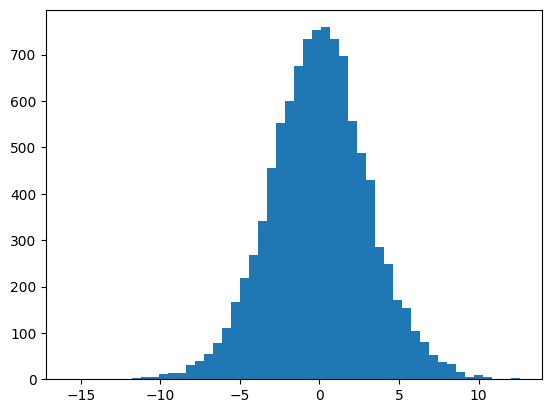

In [26]:
x = torch.randn((100, 10))
w = torch.randn((10, 100))
out = x @ w
print(f'mean={out.mean()}, stddev={out.std()}')
plt.hist(out.view(-1).numpy(), bins=50)
plt.show()

Now, if we apply a scaling factor of 1/sqrt(100) to w, we can see that our mean is nearly 0, and our stddev is nearly 1!

mean=-0.00013245668378658593, stddev=0.9498184323310852


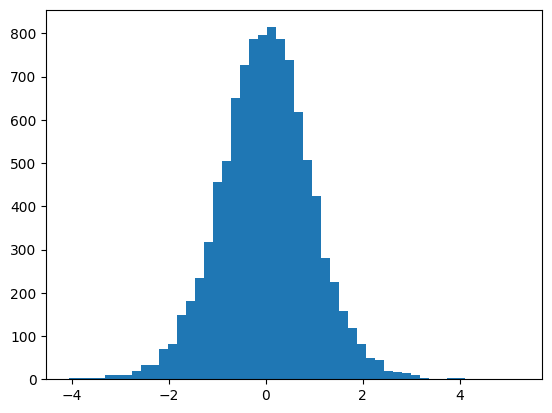

In [27]:
x = torch.randn((100, 10))
w = torch.randn((10, 100)) / torch.sqrt(torch.tensor(10))
out = x @ w
print(f'mean={out.mean()}, stddev={out.std()}')
plt.hist(out.view(-1).numpy(), bins=50)
plt.show()

In PyTorch, we can initialize nn.Module layers with *Kaiming Initialization* via *torch.nn.init.kaiming_normal_*, which applies normalization appropriate for the given activation function and layer size to acheive an identical result. (By default torch.nn.Linear normalizes to a uniform distribution)

mean=0.020203080028295517, stddev=0.9190266132354736


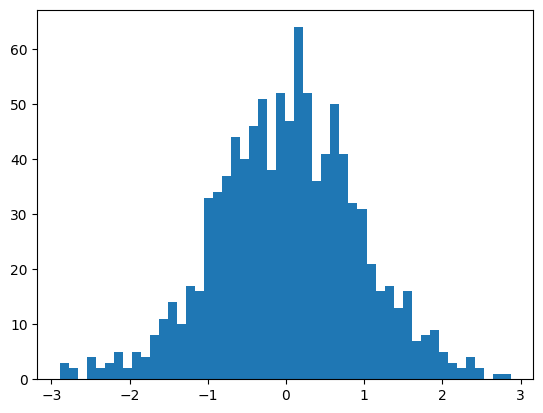

In [28]:
linear = torch.nn.Linear(10, 10, bias=False)
torch.nn.init.kaiming_normal_(linear.weight, mode='fan_in', nonlinearity='linear')
x = torch.randn((100, 10))
out = linear(x)
print(f'mean={out.mean()}, stddev={out.std()}')
plt.hist(out.view(-1).detach().numpy(), bins=50)
plt.show()

We can update our *init_parameters* function to use this initialization for our hidden layer weights. Since our hidden layer activation function is tanh, we need to apply a gain coefficient of 5/3 to account for the transformation applied by tanh.

In [29]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, weight_multiplier=0.01):
    C = torch.randn((num_chars, embedding_size))
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size)) * ((5/3) / torch.sqrt(torch.tensor(embedding_size * block_size)) )
    b1 = torch.randn(hidden_layer_size) * weight_multiplier
    W2 = torch.randn((hidden_layer_size, num_chars)) * weight_multiplier
    b2 = torch.zeros(num_chars)

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return parameters

In [30]:
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, 0.01)
losses = gradient_descent(train_X, train_Y, parameters, iterations=200000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000)

Iteration 0 loss: 3.293808698654175
Iteration 10000 loss: 2.199528694152832
Iteration 20000 loss: 2.230414628982544
Iteration 30000 loss: 2.2069666385650635
Iteration 40000 loss: 2.0752100944519043
Iteration 50000 loss: 2.219223976135254
Iteration 60000 loss: 2.0672922134399414
Iteration 70000 loss: 2.168888568878174
Iteration 80000 loss: 2.124749183654785
Iteration 90000 loss: 2.0598106384277344
Iteration 100000 loss: 2.032606601715088
Iteration 110000 loss: 1.8628500699996948
Iteration 120000 loss: 2.1929471492767334
Iteration 130000 loss: 2.158982038497925
Iteration 140000 loss: 2.0288021564483643
Iteration 150000 loss: 2.2130298614501953
Iteration 160000 loss: 2.056976318359375
Iteration 170000 loss: 2.089848041534424
Iteration 180000 loss: 2.1692745685577393
Iteration 190000 loss: 2.0957047939300537


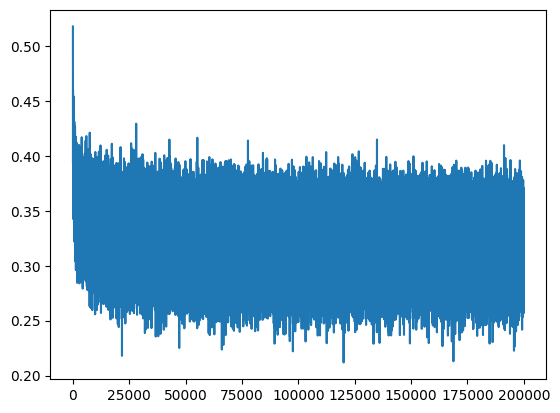

In [31]:
plt.plot(torch.tensor(losses).log10())
plt.show()

In [32]:
print(f'Train Loss = {evaluate(train_X, train_Y, parameters)}')
print(f'Dev Loss = {evaluate(dev_X, dev_Y, parameters)}')

Train Loss = 2.0856356620788574
Dev Loss = 2.1324610710144043


A more commonly-known technique for normalizing hidden-layer distributions is *batch normalization*. Rather than applying a transformation to the weights such that the outputs are gaussian, in batch normalization we just normalize the outputs themselves to be gaussian!

First, we need to modify our *init_parameters* to include parameters for the *gain* and *bias* of the hidden-layer normalization. These parameters will control the magnitude of the stddev and the shift of the mean, respectively. For example, if our data better fit a normal distriubtion shifted to the right with a tighter spread, in a gradient descent step we'd make our gain smaller and our bias larger.

In [33]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, weight_multiplier=0.01):
    C = torch.randn((num_chars, embedding_size))
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size)) * ((5/3) / torch.sqrt(torch.tensor(embedding_size * block_size)) )
    b1 = torch.randn(hidden_layer_size) * weight_multiplier
    W2 = torch.randn((hidden_layer_size, num_chars)) * weight_multiplier
    b2 = torch.zeros(num_chars)

    W1_gain = torch.ones((1, hidden_layer_size))
    W1_bias = torch.zeros((1, hidden_layer_size))
    
    parameters = [C, W1, b1, W2, b2, W1_gain, W1_bias]
    for p in parameters:
        p.requires_grad = True
    return parameters

Then, we also need to update our *forward* funciton to apply the normalization to the outputs of the hidden layer.

In [35]:
def forward(x, parameters):
    C, W1, b1, W2, b2, W1_gain, W1_bias = parameters
    emb = C[x]
    h = (emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1) + b1
    h = W1_gain * (h - h.mean(0, keepdim=True)) / h.std(0, keepdim=True) + W1_bias
    h = h.tanh()
    h = (h @ W2) + b2
    return h # returns logits

# we also need to redefine optimize_step since it uses forward
def optimize_step(x, y, parameters, lr=0.1):
    logits = forward(x, parameters)
    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    return loss.item()

def gradient_descent(x, y, parameters, iterations=100, minibatch_size=100, lr=0.1, lr_decay=0.01, print_every=10):
    losses = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        loss = optimize_step(xi, yi, parameters, lr)
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr = lr * (1 - lr_decay)
    return losses

In [37]:
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, 0.01)
losses = gradient_descent(train_X, train_Y, parameters, iterations=200000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000)

Iteration 0 loss: 3.2907679080963135
Iteration 10000 loss: 2.292905807495117
Iteration 20000 loss: 2.2677416801452637
Iteration 30000 loss: 2.0080645084381104
Iteration 40000 loss: 2.1710927486419678
Iteration 50000 loss: 2.212115526199341
Iteration 60000 loss: 2.2926361560821533
Iteration 70000 loss: 2.1141364574432373
Iteration 80000 loss: 1.9835917949676514
Iteration 90000 loss: 2.0343105792999268
Iteration 100000 loss: 2.0774405002593994
Iteration 110000 loss: 2.087632417678833
Iteration 120000 loss: 2.164548635482788
Iteration 130000 loss: 2.052622079849243
Iteration 140000 loss: 2.3752994537353516
Iteration 150000 loss: 2.1700291633605957
Iteration 160000 loss: 2.146089553833008
Iteration 170000 loss: 2.05557918548584
Iteration 180000 loss: 2.183335065841675
Iteration 190000 loss: 2.04850435256958


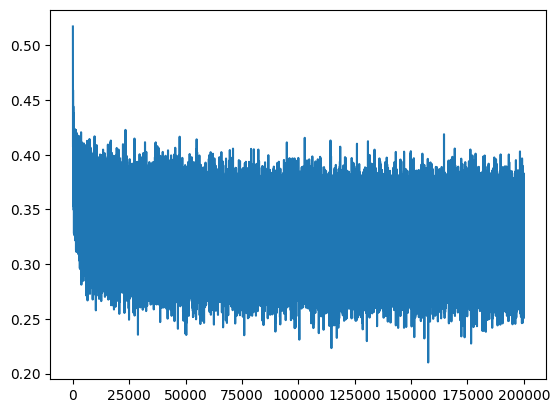

In [38]:
plt.plot(torch.tensor(losses).log10())
plt.show()

In [39]:
print(f'Train Loss = {evaluate(train_X, train_Y, parameters)}')
print(f'Dev Loss = {evaluate(dev_X, dev_Y, parameters)}')

Train Loss = 2.090341329574585
Dev Loss = 2.1275157928466797


Becuase our network is so small, we wouldn't expect to see much if any improvement in our validation loss. However, this technique is very effective with larger networks, so we'd expect to see more improvement as the size of our network grows larger -- as it becomes easier for gradients to explode or go to zero as the number of layers increases.

BatchNorm introduces a small issues -- when it's time to evaluate our model, it can become awkward to compute the mean and stddev of hidden layers in our forward pass to do batch normalization, because in many cases we might want to compute on a single example or a smaller batch of samples, but our implemenation is reliant upon having a large enough batchsize such that we can introduce proper normalization. This is not a problem during training since we can make the batches as large or as small as we want, but it'd be nice to have flexibility during evaluation wrt how many samples we feed through the model.

To solve this, we can keep track of mean and stddev statistics for each hidden layer, and then use those at test time rather than computing them on the input data. We can update our implementation as follows:

* keep track of a running mean and stddev during training
* use the running mean and stddev as the mean + stddev during evaluation
* remove bias term on the hidden layer -- it's now pointless because the activations are going to be normalized, so grad on the bias term will be zero

In [50]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, weight_multiplier=0.01):
    C = torch.randn((num_chars, embedding_size))
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size)) * ((5/3) / torch.sqrt(torch.tensor(embedding_size * block_size)) )
    W2 = torch.randn((hidden_layer_size, num_chars)) * weight_multiplier
    b2 = torch.zeros(num_chars)

    W1_gain = torch.ones((1, hidden_layer_size))
    W1_bias = torch.zeros((1, hidden_layer_size))
    
    parameters = [C, W1, W2, b2, W1_gain, W1_bias]
    for p in parameters:
        p.requires_grad = True
    return parameters

def forward(x, parameters, running_mean, running_stddev, training=True):
    C, W1, W2, b2, W1_gain, W1_bias = parameters
    emb = C[x]
    h = (emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1)
    if training:
        mean = h.mean(0, keepdim=True)
        stddev = h.std(0, keepdim=True)
        h = W1_gain * (h - mean) / stddev + W1_bias
        with torch.no_grad():
            running_mean = 0.999 * running_mean + 0.001 * mean
            running_stddev = 0.999 * running_stddev + 0.001 * stddev
    else:
        h = W1_gain * (h - running_mean) / (running_stddev + 1e-8) + W1_bias
    h = h.tanh()
    h = (h @ W2) + b2

    return h, running_mean, running_stddev # returns logits

# we also need to redefine optimize_step since it uses forward
def optimize_step(x, y, rmean, rstddev, parameters, lr=0.1):
    logits, rmean, rstddev = forward(x, parameters, rmean, rstddev, training=True)
    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    return loss.item(), rmean, rstddev

def gradient_descent(x, y, parameters, rmean, rstddev, iterations=100, minibatch_size=100, lr=0.1, lr_decay=0.01, print_every=10):
    losses = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        loss, rmean, rstddev = optimize_step(xi, yi, rmean, rstddev, parameters, lr)
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr *= (1 - lr_decay)
    return losses, rmean, rstddev

def evaluate(x, y, rmean, rstddev, parameters):
    logits, _, _ = forward(x, parameters, rmean, rstddev, training=False)
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

This is an unwieldy implementation, pytorch ties these statistics to the layer itself via class variables, but so far our in our lessons we have not been defining layers as classes, so this implementation will do for now...

In [52]:
rmean = torch.zeros((1, hidden_layer_size))
rstddev = torch.ones((1, hidden_layer_size))
parameters = init_parameters(num_chars, block_size, embedding_size, hidden_layer_size, 0.01)
losses, rmean, rstddev = gradient_descent(train_X, train_Y, parameters, rmean, rstddev, iterations=200000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000)

Iteration 0 loss: 3.3033158779144287
Iteration 10000 loss: 2.4099843502044678
Iteration 20000 loss: 2.182055711746216
Iteration 30000 loss: 2.254995107650757
Iteration 40000 loss: 2.1473259925842285
Iteration 50000 loss: 2.196575880050659
Iteration 60000 loss: 2.174363851547241
Iteration 70000 loss: 2.1452932357788086
Iteration 80000 loss: 2.0163846015930176
Iteration 90000 loss: 2.216341733932495
Iteration 100000 loss: 2.280031204223633
Iteration 110000 loss: 2.2316977977752686
Iteration 120000 loss: 2.211935043334961
Iteration 130000 loss: 2.145080327987671
Iteration 140000 loss: 2.113131523132324
Iteration 150000 loss: 2.072510242462158
Iteration 160000 loss: 2.0126073360443115
Iteration 170000 loss: 1.8976560831069946
Iteration 180000 loss: 2.069079637527466
Iteration 190000 loss: 2.175325870513916


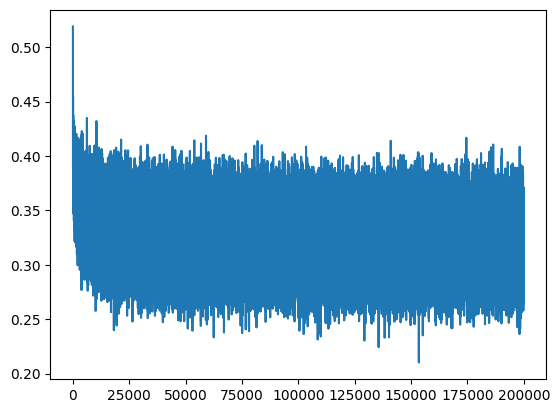

In [53]:
plt.plot(torch.tensor(losses).log10())
plt.show()

In [54]:
print(f'Train Loss = {evaluate(train_X, train_Y, rmean, rstddev, parameters)}')
print(f'Dev Loss = {evaluate(dev_X, dev_Y, rmean, rstddev, parameters)}')

Train Loss = 2.0912718772888184
Dev Loss = 2.129659652709961


At this point our implementation is getting a bit messy, we can clean it up by implementing layers as classes that we can use in a modular way. This will also allows us to keep track of batchnorm running mean and stddev much more elegantly.


First we'll define the Linear layer, we need to:
* Initialize weights and bias parameters (normalized)
* Implement the forward pass

In [55]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weights = torch.randn((fan_in, fan_out)) / torch.sqrt(torch.tensor(fan_in)) # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x): # 'forward'
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights, self.bias] if self.bias is not None else [self.weights]

We can quickly test our implementation and make sure that it follows the distribution we expect:

stddev=1.0708191394805908, mean=0.0016586141427978873


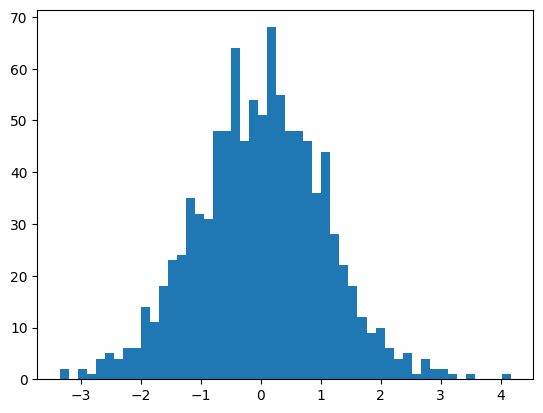

In [56]:
l = Linear(10, 10)
x = torch.randn((100, 10))
out = l(x)
print(f'stddev={out.std()}, mean={out.mean()}')
plt.hist(out.detach().numpy().flatten(), bins=50)
plt.show()

Next up is BatchNorm, we need to:
* keep track of running mean, variance (we did stddev last time but it's usually implemented with variance)
* maintain gain and bias parameters
* use batch mean, var during training and use running mean, var during eval

In [57]:
class BatchNorm:
    def __init__(self, dim, eps=1e-6, momentum=0.1, training=True) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = training

        # gain and bias (gamma and beta)
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # running mean and variance
        self.running_mean = torch.zeros(dim)
        self.running_variance = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            mean = x.mean(0, keepdim=True)
            variance = x.var(0, keepdim=True)
        else:
            mean = self.running_mean
            variance = self.running_variance
        
        xout = (x - mean) / torch.sqrt(variance + self.eps)
        self.out = (xout * self.gain) + self.bias

        if self.training:
            with torch.no_grad():
                self.running_mean = ((1 - self.momentum) * self.running_mean) + (self.momentum * mean)
                self.running_variance = ((1 - self.momentum) * self.running_variance) + (self.momentum * variance)
        
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]
        

We can test our implementation on some random data to see that it is normalized:

stddev=0.9954847693443298, mean=-4.529952857268427e-09


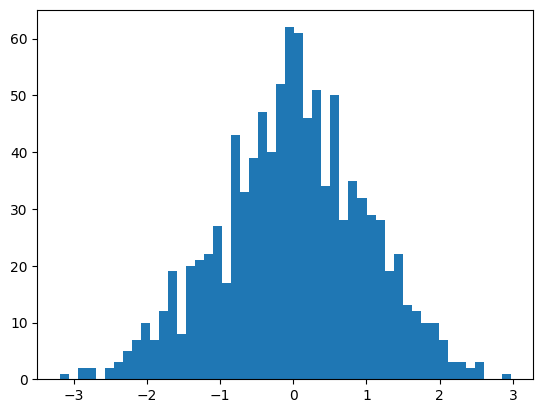

In [58]:
bn = BatchNorm(10)
bn_out = bn(torch.randn((100, 10)))
print(f'stddev={bn_out.std()}, mean={bn_out.mean()}')
plt.hist(bn_out.detach().numpy().flatten(), bins=50)
plt.show()

In [59]:
bn.running_mean, bn.running_variance

(tensor([[ 0.0112,  0.0294, -0.0132, -0.0279,  0.0006, -0.0127, -0.0127, -0.0025,
           0.0047,  0.0004]]),
 tensor([[1.0067, 0.9947, 0.9789, 0.9880, 0.9876, 1.0117, 0.9952, 0.9914, 1.0070,
          0.9708]]))

A tanh activation is very easy!

In [60]:
class Tanh:
    def __init__(self) -> None:
        pass

    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        return []

Putting it all together, we can define a network as a list of layers:

*We will come back to BatchNorm soon*

In [111]:
embeddings = torch.randn((num_chars, embedding_size))
layers = [
    Linear(embedding_size * block_size, hidden_layer_size), 
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, num_chars)
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3 # kaiming gain for tanh
    layers[-1].weights *= 0.1

parameters = [embeddings] + [p for layer in layers for p in layer.parameters()]
print(f'Number of Parameters: {sum(p.numel() for p in parameters)}')
for p in parameters:
    p.requires_grad = True


Number of Parameters: 46497


Then, we can define our forward, optimize_step, and gradient_descent functions w.r.t. this new design (they look almost identical)

In [112]:
def forward(layers, embeddings, x):
    x = embeddings[x]
    x = x.view(x.shape[0], -1)
    for layer in layers:
        x = layer(x)
    return x

def optimize_step(x, y, layers, embeddings, parameters, lr, debug=False):
    for p in parameters:
        p.grad = None
    logits = forward(layers, embeddings, x)
    loss = torch.nn.functional.cross_entropy(logits, y)
    
    if debug:
        for layer in layers:
            layer.out.retain_grad()
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        
    return loss.item()

def gradient_descent(x, y, layers, embeddings, parameters, iterations, minibatch_size, lr, lr_decay, print_every, debug=False):
    losses = []
    ud = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        loss = optimize_step(xi, yi, layers, embeddings, parameters, lr, debug)
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr *= (1 - lr_decay)
    return losses

Now we can visualize the activations of the Tanh layers to get a better idea of how data is propagating through the network -- in order to make sure that we maintain a good distribution and don't suffer from a large number of dead neurons. We've taken appropriate steps to ensure that our distribution stays normal, so we observe that the std maintains a value of around 0.67 (in line with the gain we set) and the mean maintains a value of around 0.0.

In [113]:
gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)

Iteration 0 loss: 3.2949304580688477


[3.2949304580688477]

Layer 1 mean=-0.03, stddev=0.77, saturation=23.85%
Layer 3 mean=-0.02, stddev=0.70, saturation=10.55%
Layer 5 mean=-0.02, stddev=0.67, saturation=6.68%
Layer 7 mean=+0.02, stddev=0.66, saturation=5.88%
Layer 9 mean=+0.01, stddev=0.65, saturation=6.05%


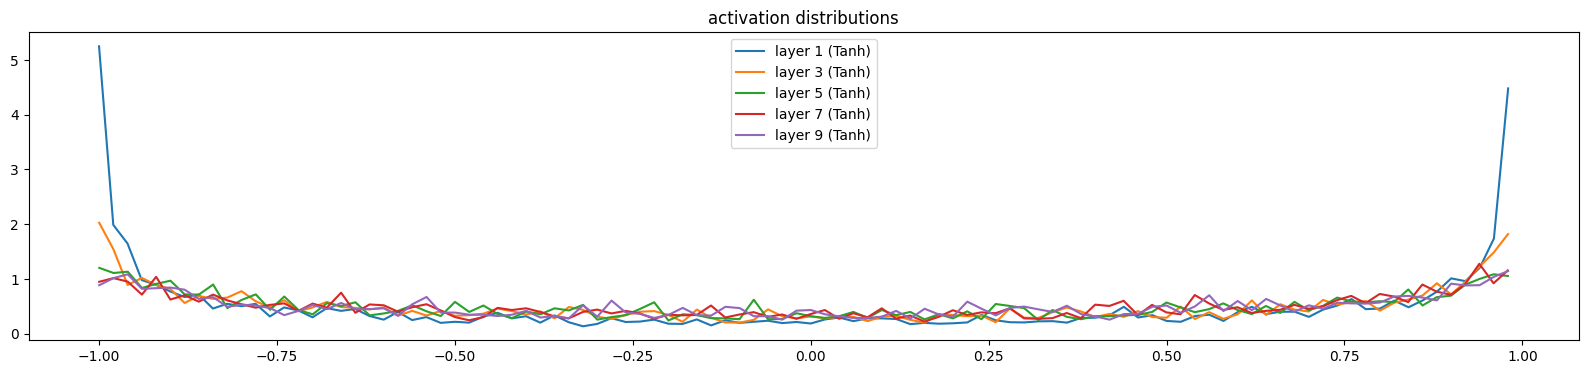

In [114]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f'Layer {i} mean={t.mean():+.2f}, stddev={t.std():.2f}, saturation={(t.abs() > 0.97).float().mean()*100:.2f}%'
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distributions')
plt.show()

We can also run the same analysis on the layer gradients. One of the things we'd like to look out for is shrinking/exploding gradients as that will greatly impede our model's abilitiy to learn. We see that each layer's gradients take on roughly the same distribution, showing that the gradient distribution remains roughly constant as data flows through the network, which is healthy.

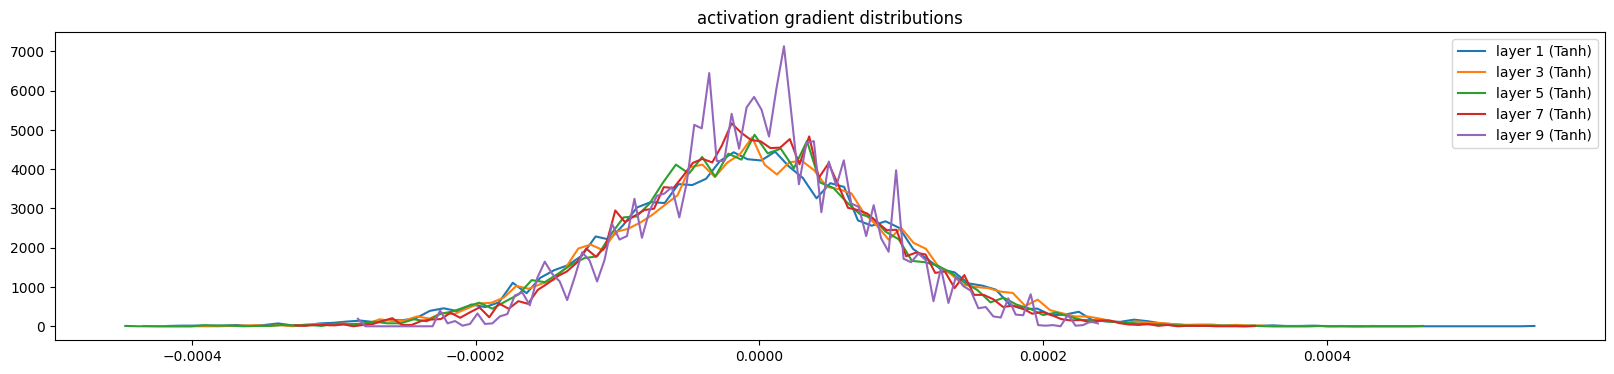

In [115]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation gradient distributions')
plt.show()

We get these nice distributions because we have carefully set the gain values during kaiming initialization... if we get these values wrong the plots above will look way less nice. In our case it was fairly simple because we just have linear-tanh pairs -- but for a more commplicated network setting gain values correctly (and verifying that they are indeed correct) can be quite tedious. That is one of the reasons why BatchNorm is so useful, it does the tedious work of maintaining healthy distributions trivial!

weight shape=torch.Size([27, 10]) mean=+0.00005, stddev=0.00056, grad:data ratio=0.00052
weight shape=torch.Size([30, 100]) mean=+0.00000, stddev=0.00070, grad:data ratio=0.00232
weight shape=torch.Size([100, 100]) mean=+0.00001, stddev=0.00056, grad:data ratio=0.00330
weight shape=torch.Size([100, 100]) mean=+0.00000, stddev=0.00054, grad:data ratio=0.00323
weight shape=torch.Size([100, 100]) mean=-0.00001, stddev=0.00048, grad:data ratio=0.00289
weight shape=torch.Size([100, 100]) mean=-0.00000, stddev=0.00047, grad:data ratio=0.00279
weight shape=torch.Size([100, 27]) mean=+0.00000, stddev=0.01346, grad:data ratio=1.28316


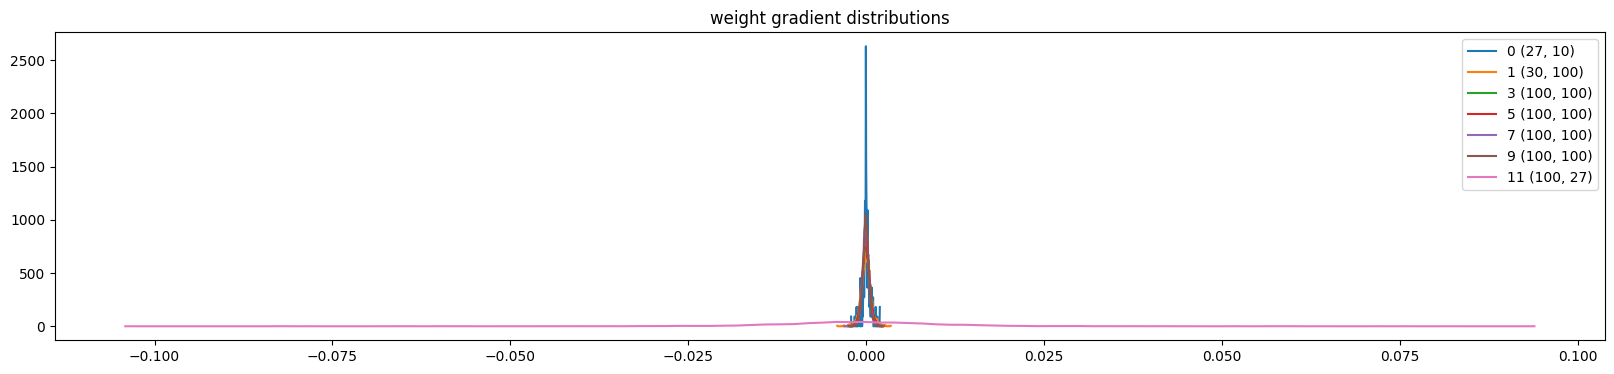

In [117]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # only consider weight matrices
        print(f'weight shape={p.shape} mean={t.mean():+.5f}, stddev={t.std():.5f}, grad:data ratio={(t.std() / p.std()):.5f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distributions')
plt.show()

If we plot the gradients of the parameters, we can see that the output layer (pink) takes on a much wider range of values than the other layers. This makes sense, because we do not apply an activation to that layer. However, this is potentially an issue because it means that at initialization, the output layer weights will be training much faster (due to larger gradient) than all the other layers. However, this tends to quickly remedy itself as we run more iterations. 

If we run gradient descent for a few iterations, we get something a bit nicer:

Iteration 0 loss: 3.2580039501190186
weight shape=torch.Size([27, 10]) mean=-0.00076, stddev=0.00656, grad:data ratio=0.00606
weight shape=torch.Size([30, 100]) mean=+0.00018, stddev=0.00610, grad:data ratio=0.01991
weight shape=torch.Size([100, 100]) mean=+0.00003, stddev=0.00448, grad:data ratio=0.02603
weight shape=torch.Size([100, 100]) mean=-0.00002, stddev=0.00427, grad:data ratio=0.02506
weight shape=torch.Size([100, 100]) mean=+0.00001, stddev=0.00397, grad:data ratio=0.02343
weight shape=torch.Size([100, 100]) mean=+0.00002, stddev=0.00339, grad:data ratio=0.01989
weight shape=torch.Size([100, 27]) mean=-0.00000, stddev=0.01222, grad:data ratio=0.14240


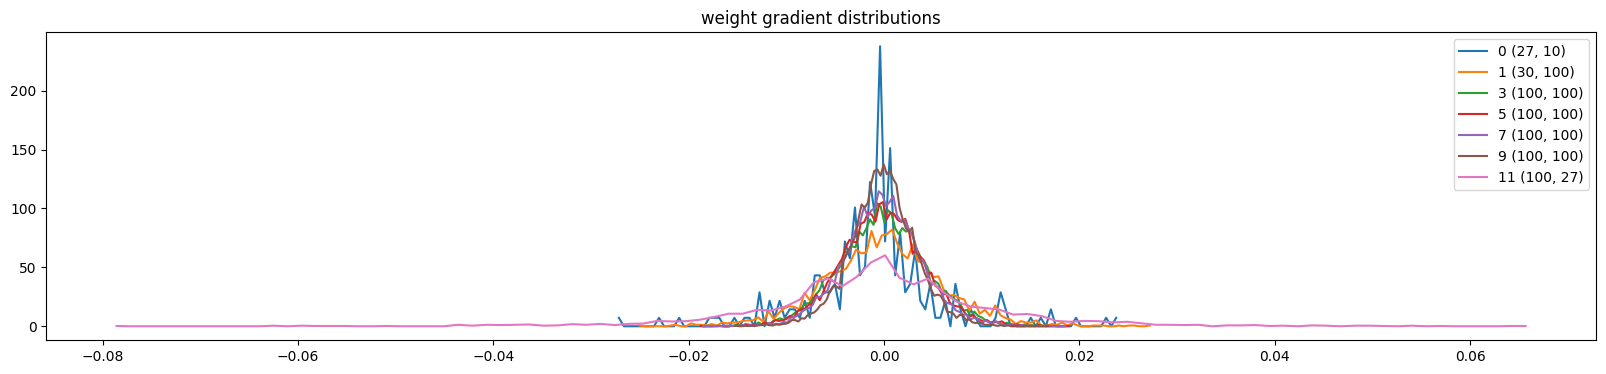

In [118]:
gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # only consider weight matrices
        print(f'weight shape={p.shape} mean={t.mean():+.5f}, stddev={t.std():.5f}, grad:data ratio={(t.std() / p.std()):.5f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distributions')
plt.show()

One final metric we'd like to analyze is the update:data ratio -- or the magnitude of updates applied to parameters in each layer. We'd like to avoid situations where the magnitudes of updates vary greatly across layers in the network.

We can accomplish this by comparing the update applied to the parameter to the parameter itself -- since we are moreso concerned with the shape of the distributions of updates across timesteps, we will compare the standard deviations.

In [119]:
def gradient_descent(x, y, layers, embeddings, parameters, iterations, minibatch_size, lr, lr_decay, print_every, debug=False):
    losses = []
    ud = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        loss = optimize_step(xi, yi, layers, embeddings, parameters, lr, debug)
        losses.append(loss)
        with torch.no_grad():
            ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr *= (1 - lr_decay)
    return losses, ud

In [123]:
embeddings = torch.randn((num_chars, embedding_size))
layers = [
    Linear(embedding_size * block_size, hidden_layer_size), 
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, num_chars)
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3 # kaiming gain for tanh
    layers[-1].weights *= 0.1

parameters = [embeddings] + [p for layer in layers for p in layer.parameters()]
print(f'Number of Parameters: {sum(p.numel() for p in parameters)}')
for p in parameters:
    p.requires_grad = True
losses, ud = gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)

Number of Parameters: 46497
Iteration 0 loss: 3.2968502044677734


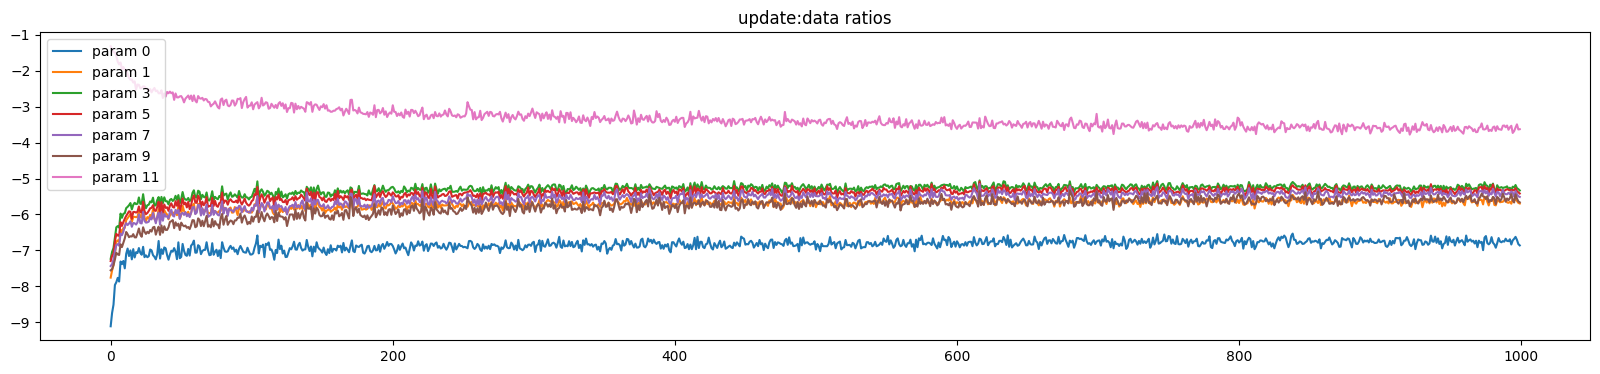

In [143]:
import numpy as np
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # only consider weight matrices
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.legend(legends)
plt.title('update:data ratios')
plt.show()

We can see that out output layer ud ratio starts very high but quickly becomes more normal.

Now let's reintroduce BatchNorm layers into the network, and see that the distributions look even more homogenous across layers.

In [149]:
embeddings = torch.randn((num_chars, embedding_size))
layers = [
    Linear(embedding_size * block_size, hidden_layer_size), 
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, num_chars)
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3 # kaiming gain for tanh
    layers[-1].weights *= 0.1

parameters = [embeddings] + [p for layer in layers for p in layer.parameters()]
print(f'Number of Parameters: {sum(p.numel() for p in parameters)}')
for p in parameters:
    p.requires_grad = True
losses, ud = gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)

Number of Parameters: 47497
Iteration 0 loss: 3.2967967987060547


Layer 2 mean=+0.00, stddev=0.63, saturation=3.50%
Layer 5 mean=-0.00, stddev=0.64, saturation=3.30%
Layer 8 mean=-0.00, stddev=0.64, saturation=3.14%
Layer 11 mean=-0.00, stddev=0.65, saturation=2.95%
Layer 14 mean=+0.00, stddev=0.66, saturation=2.84%


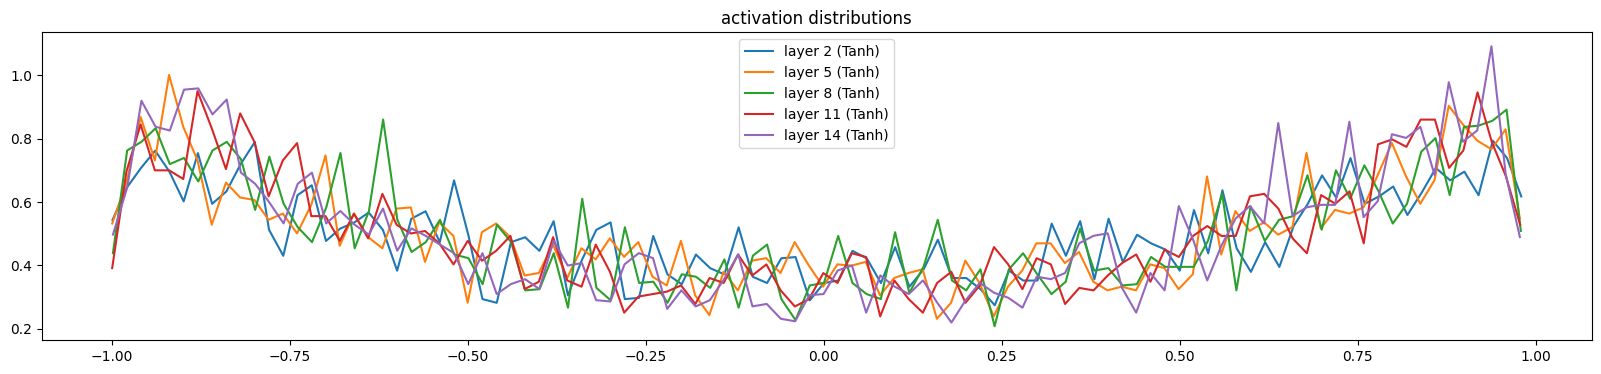

In [150]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f'Layer {i} mean={t.mean():+.2f}, stddev={t.std():.2f}, saturation={(t.abs() > 0.97).float().mean()*100:.2f}%'
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distributions')
plt.show()

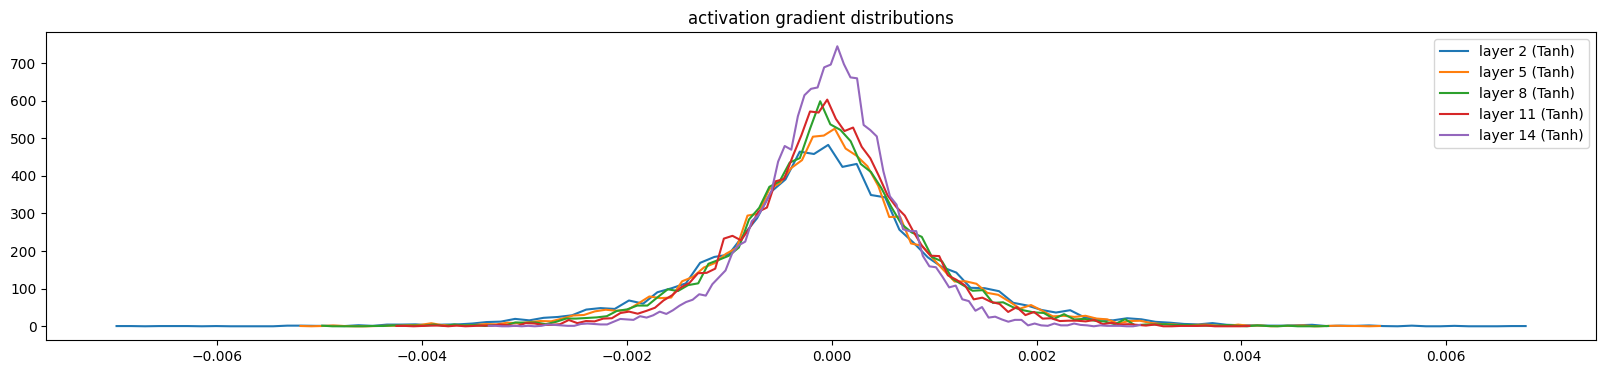

In [151]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation gradient distributions')
plt.show()

weight shape=torch.Size([27, 10]) mean=-0.00000, stddev=0.00544, grad:data ratio=0.00545
weight shape=torch.Size([30, 100]) mean=-0.00000, stddev=0.00516, grad:data ratio=0.01740
weight shape=torch.Size([100, 100]) mean=-0.00001, stddev=0.00431, grad:data ratio=0.02548
weight shape=torch.Size([100, 100]) mean=+0.00001, stddev=0.00375, grad:data ratio=0.02253
weight shape=torch.Size([100, 100]) mean=-0.00001, stddev=0.00339, grad:data ratio=0.01990
weight shape=torch.Size([100, 100]) mean=-0.00001, stddev=0.00274, grad:data ratio=0.01634
weight shape=torch.Size([100, 27]) mean=+0.00000, stddev=0.00923, grad:data ratio=0.11262


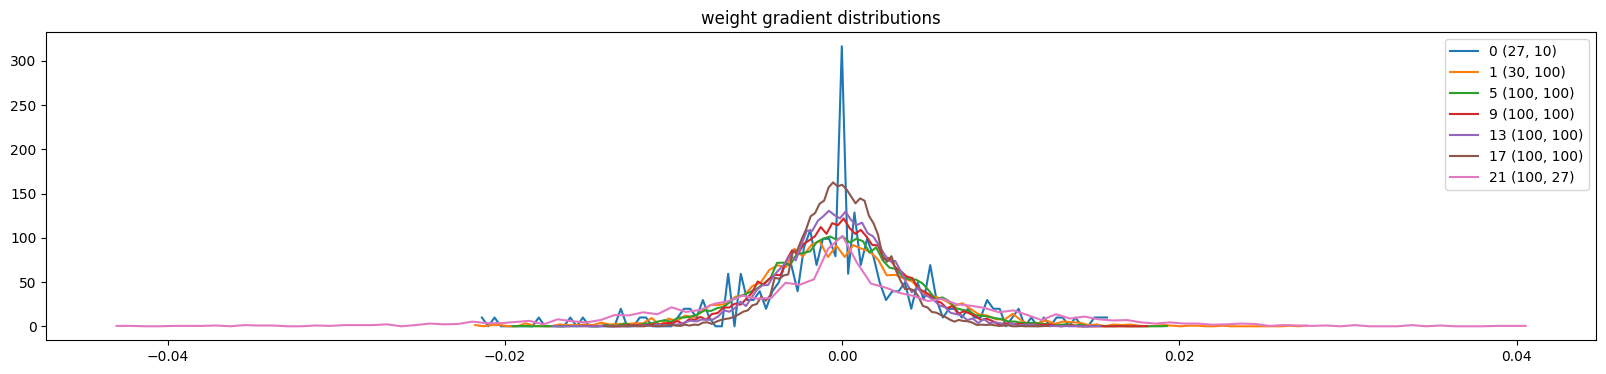

In [152]:

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # only consider weight matrices
        print(f'weight shape={p.shape} mean={t.mean():+.5f}, stddev={t.std():.5f}, grad:data ratio={(t.std() / p.std()):.5f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distributions')
plt.show()

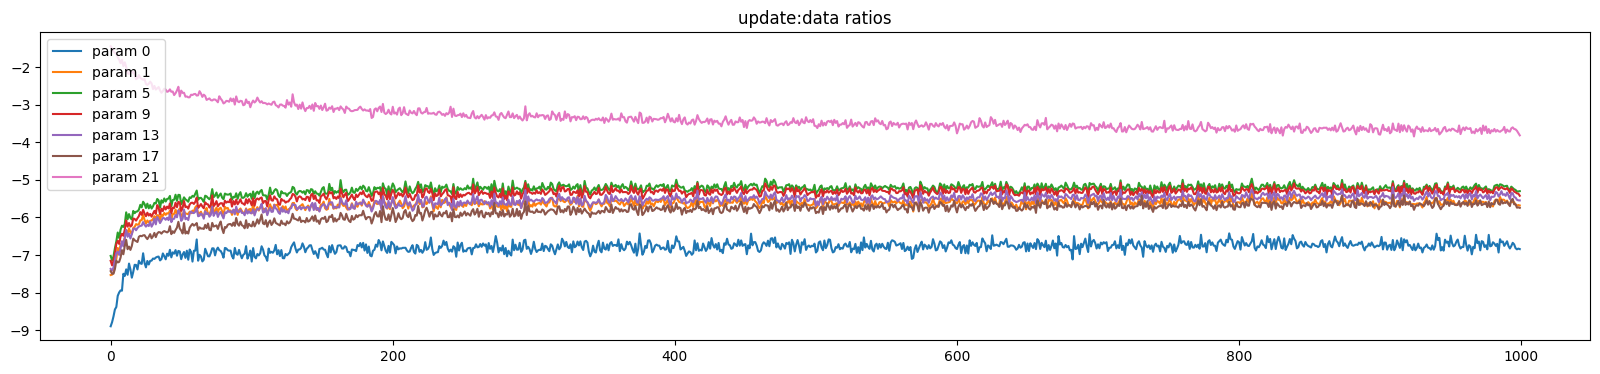

In [153]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # only consider weight matrices
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.legend(legends)
plt.title('update:data ratios')
plt.show()

BatchNorm allows our model to be more robust -- our distributions throughout layers will likely still be fine even if we don't spend lots of time applying the correct gain and initialization to parameters!